The purpose of this notebook, it to use networks of artists collaborations to learn about hot-100 billboard chart rankings.

**Note:** This notebook contains interactive bokeh charts that work better if the notebook is cloned on local directory

In [10]:
import json, glob
import numpy as np
from itertools import groupby, combinations, cycle
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt, log10, log

In [11]:
# import chart data
filenames = glob.glob('data/2016*')
chart_data = []
for filename in filenames:
    with open(filename,'r') as f:
        chart_data.extend(json.load(f))
        f.close()

Let's prepare the track data such that we can extract every track's artist. We going to write function that takes a track dictionary and spits a tuple with 3 elements (artist1, artist2,1). artist2 will be None for each track sang by a single artist

In [12]:
chart_data[0]

{u'artist': u'Adele',
 u'change': u'0',
 u'date': u'2016-01-02',
 u'lastPos': 1,
 u'peakPos': 1,
 u'rank': 1,
 u'spotifyID': u'1MDoll6jK4rrk2BcFRP5i7',
 u'spotifyLink': u'https://embed.spotify.com/?uri=spotify:track:1MDoll6jK4rrk2BcFRP5i7',
 u'title': u'Hello',
 u'videoLink': u'',
 u'weeks': 8}

In [13]:
def get_artist(track):
    artists = clean_artist_text(track['artist'])
    if len(artists)==1:
        for i in range(2):
            yield (artists[0],None,1)
    if len(artists)>1:
        combs = list(combinations(sorted(artists,reverse=False),2))#+list(combinations(sorted(artists,reverse=True),2))
        for comb in combs:
            yield (comb[0],comb[1],1)

def clean_artist_text(txt):
    patterns = ['Featuring','Feat.','With',' x ',' or ',' and ',
                '+',',',' And ']
    for pat in patterns:
        txt = txt.replace(pat,'&')
    s = txt.split('&')
    s = map(lambda x:x.strip().strip('.').lower().title(),s)
    
    return s

def get_track_ranking(track):
    title = track['title']
    rank = track['rank']
    artists = clean_artist_text(track['artist'])
    if len(artists) == 1:
        yield (artists[0],title,rank)
    else:
        for artist in artists:
            yield (artist,title,rank)

In [15]:
#get_artist returns chains that need to be converted into list of tuples.
#tuples are then aggregated together and sorted
l1 = sorted(reduce(lambda x,y:x+y,map(lambda x:list(get_artist(x)),chart_data)))

edges = list(set([(k[0],k[1],len(list(v))) for k,v in groupby(l1)]))
vertices = filter(lambda x:x!=None,sorted(list(set(reduce(lambda x,y:x+y,map(lambda x:list(x)[:2],edges))))))
vert1 = sorted(map(lambda x:x[0],filter(lambda x:x[1]==None,edges)))
edges = filter(lambda x:x[1]!=None,edges)

def assign_color(vertex):
    c = 'blue'
    if vertex in vert1:
        c = 'green'
    return c
colors = map(lambda x:assign_color(x),vertices)
numRepeats = dict(filter(lambda x:x[0]!=None,[[k,len(list(v))] for k,v in groupby(sorted(reduce(lambda x,y:x+y,map(lambda x:list(x)[:2],l1))))]))

# aritst best positions
l2 = sorted(reduce(lambda x,y:x+y,map(lambda x:list(get_track_ranking(x)),chart_data)))
artist_ranks = [(k,map(lambda x:x[1],list(v))) for k,v in groupby(map(lambda x:(x[0],x[2]),l2),max)]
artist_hpos = dict(map(lambda x:(x[0],(101 - min(x[1]))/100.),artist_ranks))

#artist best song
artist_btrack = {}
for v in map(lambda x:(x[0],min(x[1])),artist_ranks):
    r = filter(lambda x:(x[0]==v[0]) & (x[2]==v[1]),l2)[0]
    artist_btrack[r[0]] = r[1]
    

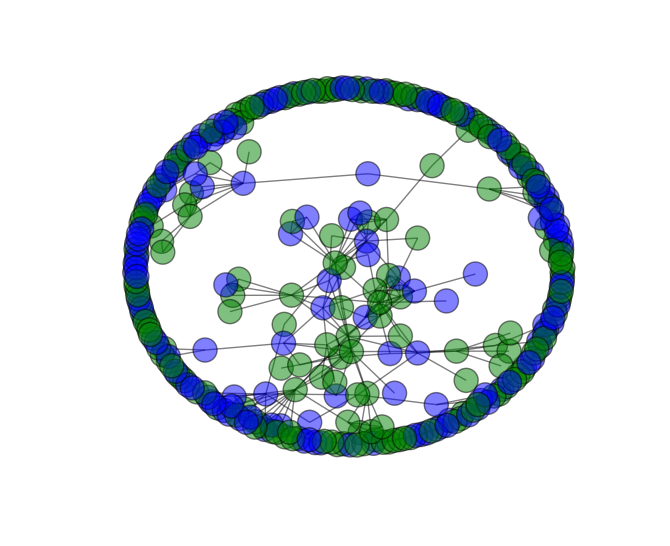

In [23]:
# initiate graph
bbGraph = nx.Graph()
# add nodes
bbGraph.add_nodes_from(vertices)
# add edges
bbGraph.add_edges_from(map(lambda x:(x[0],x[1]),edges))

plt.figure(figsize=(6,5))
nx.draw_spring(bbGraph,alpha=0.5,node_color=colors)
plt.show()

In [24]:
layout = nx.spring_layout(bbGraph,
                                k=1.5/sqrt(bbGraph.number_of_nodes()),
                                iterations=50)

numConnect = nx.degree(bbGraph)

In [25]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import HoverTool

nodes, nodes_coordinates = zip(*sorted(layout.items()))
nodes_xs, nodes_ys = list(zip(*nodes_coordinates))
nodes_source = ColumnDataSource(dict(x=nodes_xs, y=nodes_ys,
                                     name=nodes,color=colors,
                                     numConnect = map(lambda x:numConnect[x],nodes),
                                     numRepeats1 = map(lambda x:5*(log(numRepeats[x])+1),nodes),
                                     numRepeats2 = map(lambda x:numRepeats[x],nodes),
                                     highPos1 = map(lambda x:101-100*artist_hpos[x],nodes),
                                     highPos2 = map(lambda x:30*artist_hpos[x],nodes),
                                     bestTrack = map(lambda x:artist_btrack[x],nodes),
                                    )
                               )

In [27]:
hover = HoverTool(tooltips=[('Name', '@name'), ('#connections', '@numConnect'),
                            ('Frequency','@numRepeats2'),
                            ('HighestPosition','@highPos1'),
                            ('BestTrack','@bestTrack')])
plot = figure(plot_width=600, plot_height=400,
              tools=['tap', hover, 'box_zoom', 'reset'])
r_circles = plot.circle('x', 'y', source=nodes_source, size='numRepeats1',
                        color='color', level = 'overlay',alpha=0.5)

def get_edges_specs(_network, _layout):
    # example: { ..., ('user47', 'da_bjoerni', {'weight': 3}), ... }
    d = dict(xs=[], ys=[])
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
    return d
lines_source = ColumnDataSource(get_edges_specs(bbGraph, layout))
r_lines = plot.multi_line('xs', 'ys', line_width=1, color='navy',
                          source=lines_source)
output_notebook(); show(plot)

Loading BokehJS ...

In [20]:
act = [(k,len(list(v))) for k,v in groupby(sorted(colors))]
print '{0}% of artists made it to the hot-100 chart thanks to their collaboration (blue bubble)'.format(round(100*act[0][1]/float(act[0][1]+act[1][1])))

43.0% of artists made it to the hot-100 chart thanks to their collaboration (blue bubble)
